# Project 1: Document author identification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [30]:
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 1. Read the file and import data

In [3]:
import json

# read json file
def read_json(path):
    with open(path, 'r') as file:
         temp = json.load(file)
    df = pd.DataFrame(temp).T
    return df

In [4]:
train_df = read_json('comp90051-22-s1-p1/train.json')
train_df.head(5)

,venue,keywords,year,author
0,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,"[1605, 759]"
1,0,"[258, 260, 389, 261, 390, 396, 400, 17, 146, 2...",2013,[2182]
2,1,"[320, 454, 266, 462, 17, 339, 404, 342, 407, 2...",2007,[2176]
3,2,"[260, 132, 333, 15, 400, 272, 146, 401, 278, 3...",2013,[1107]
4,3,"[64, 385, 449, 450, 71, 73, 268, 80, 216, 25, ...",2009,[1414]


In [5]:
test_df = read_json('comp90051-22-s1-p1/test.json')
test_df.head(5)

,venue,keywords,year,coauthor,target
0,,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",2017,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",2019,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",2014,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",2010,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",2016,[1107],995


In [6]:
# print dimension for each dataframe
print(f"shape of train_df    = {train_df.shape}")
print(f"shape of test_df     = {test_df.shape}")

shape of train_df    = (26108, 4)
shape of test_df     = (2000, 5)


## 2. Create Label

In [7]:
def get_transformed_df(df):
    aus = df['author']
    transformed_lst = []
    for i in range(df.shape[0]):
        for j in aus[i]:
            temp = list(df.values[i][:-1])
            temp.append([au for au in aus[i] if au!=j])
            temp.append(j)
            transformed_lst.append(temp)
    cols = list(df.columns[:-1])
    cols.append('coauthor')
    cols.append('target')
    return pd.DataFrame(transformed_lst,columns=cols)

In [8]:
transformed_df = get_transformed_df(train_df)

In [9]:
transformed_df.head()

,venue,keywords,year,coauthor,target
0,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,[759],1605
1,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,[1605],759
2,0,"[258, 260, 389, 261, 390, 396, 400, 17, 146, 2...",2013,[],2182
3,1,"[320, 454, 266, 462, 17, 339, 404, 342, 407, 2...",2007,[],2176
4,2,"[260, 132, 333, 15, 400, 272, 146, 401, 278, 3...",2013,[],1107


## 3. One-hot

In [10]:
import torch
def get_onehot_col(col, size, col_prefix):
    transformed_col = []
    for i in col:
        transformed_col.append(torch.zeros(size, dtype=torch.int).scatter_(0, torch.tensor(i), value=1).tolist())
    col_names = [col_prefix+'_'+str(i) for i in range(size)]
    return pd.DataFrame(transformed_col, columns=col_names)

In [11]:
transformed_df.loc[transformed_df['venue']=='',['venue']]=470
venue_transformed = get_onehot_col(transformed_df['venue'], 471, "venue")

#keywords_transformed = get_onehot_col(transformed_df['keywords'], 500, "keywords")

transformed_df['year'] = transformed_df['year']-2000
year_transformed = get_onehot_col(transformed_df['year'], 20, "year")

coauthor_transformed = get_onehot_col(transformed_df['coauthor'], 2302, "coauthor")

target_transformed = get_onehot_col(transformed_df['target'], 2302, "target")




## 3. node2vec for keywords

In [23]:
# get nodes and edges for keyword graph
edges = []
nodes = set()
for kws in transformed_df['keywords']:
    for i in kws:
        for j in kws:
            if i != j:
                nodes.add(i)
                edges.append((i,j))
                

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph using nodes and edges
G_kws = nx.Graph()
G_kws.add_nodes_from(list(nodes))
G_kws.add_edges_from(edges)

In [25]:
from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec

# create the random walk using the graph
walker = RandomWalker(walk_length = 80, walk_number = 100)
walker.do_walks(G_kws)

In [33]:
WINDOW_SIZE_KEYWORDS = 6
VECTOR_SIZE_KEYWORDS = 12

model_kws = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=VECTOR_SIZE_KEYWORDS,  # size of the embedding
                 window=WINDOW_SIZE_KEYWORDS,
                 epochs = 1,
                 min_count =1,
                 workers=4,
                 seed=42)

In [34]:
embedding_kws = model_kws.wv.vectors
embedding_kws.shape

(500, 12)

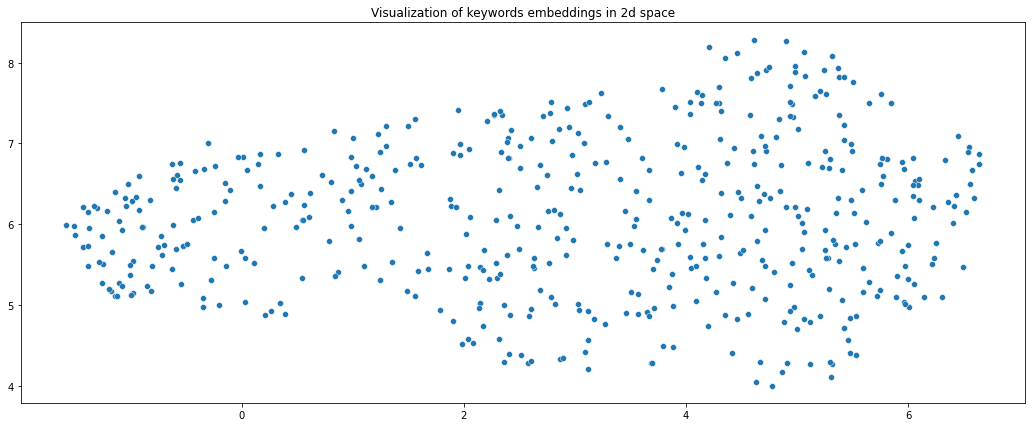

In [35]:
import umap.umap_ as umap
import seaborn as sns


u = umap.UMAP(random_state=90051)
umap_embs_kws = u.fit_transform(embedding_kws)

ax = sns.scatterplot(x = umap_embs_kws[:, 0], y = umap_embs_kws[:, 1]).set(title="Visualization of keywords embeddings in 2d space")



In [36]:
def convert_to_emb(lst, model):
    curr = []
    for i in lst:
        try:
            curr.append(model.wv.get_vector(i))
        except:
            continue
    if curr == []:
        return list([0 for i in range(model.vector_size)])
    return np.mean(np.array(curr), axis=0).tolist()


keywords_tran = []
for row in transformed_df['keywords']:
    keywords_tran.append(convert_to_emb(row, model_kws ))

keywords_cols = ["keyword_"+str(i) for i in range(VECTOR_SIZE_KEYWORDS)]
keywords_transformed_node2vec = pd.DataFrame(keywords_tran, columns=keywords_cols)






In [23]:
keywords_transformed_tfidf.head()

,keywords_0,keywords_1,keywords_2,keywords_3,keywords_4,keywords_5,keywords_6,keywords_7,keywords_8,keywords_9,...,keywords_480,keywords_481,keywords_482,keywords_483,keywords_484,keywords_485,keywords_486,keywords_487,keywords_488,keywords_489
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.139497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.177834,0.187039,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.203782,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## 3. Combine

In [37]:

#transformed_df_comb = pd.concat([venue_transformed,keywords_transformed,keywords_transformed_tfidf,year_transformed,transformed_df['year'], coauthor_transformed],axis=1)
transformed_df_comb = pd.concat([venue_transformed,keywords_transformed_node2vec,year_transformed, coauthor_transformed],axis=1)



In [38]:
transformed_df_comb['target'] = transformed_df['target'].values

In [39]:
transformed_df_comb.head()

,venue_0,venue_1,venue_2,venue_3,venue_4,venue_5,venue_6,venue_7,venue_8,venue_9,...,coauthor_2293,coauthor_2294,coauthor_2295,coauthor_2296,coauthor_2297,coauthor_2298,coauthor_2299,coauthor_2300,coauthor_2301,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1605
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,759
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2182
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2176
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1107


## 2. Train test split

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val,y_train,   y_val = train_test_split(transformed_df_comb.iloc[:,:-1], transformed_df_comb['target'],test_size=0.2, random_state=90051)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_val   shape: {}, y_val   shape: {}".format(X_val.shape, y_val.shape))



X_train shape: (38400, 2805), y_train shape: (38400,)
X_val   shape: (9600, 2805), y_val   shape: (9600,)


In [41]:
X_val_pos = X_val
X_val_neg = X_val
y_val_pos = y_val
y_val_neg = pd.Series(np.random.choice([i for i in range(2302)], 14400))
X_val_comb = pd.concat([X_val_pos, X_val_neg],axis = 0)
y_val_comb = y_val_pos.append(y_val_neg, ignore_index=True)

true_label = [1 for i in range(X_val_pos.shape[0])]+[0 for i in range(X_val_pos.shape[0])]
print("X_val_comb shape: ", X_val_comb.shape)
print("y_val_comb shape: ", y_val_comb.shape)

X_val_comb shape:  (19200, 2805)
y_val_comb shape:  (24000,)


## 3. Model: Gaussian NB

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB


clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

GaussianNB()

In [49]:
from sklearn.metrics import roc_auc_score

pred_NB = clf_NB.predict_proba(X_val_comb)
res = []
for i in range(len(pred_NB)):
    res.append(pred_NB[i][y_val_comb[i]])

roc_auc_score(true_label, res) # 0.7447384168836806

0.7447384168836806

## 3. Model: Logistic Regression

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

- C=0.1

In [46]:
%%time

clf_LR_01 = LogisticRegression(multi_class="multinomial", C=0.1, verbose=True)
clf_LR_01.fit(X_train, y_train)      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      6459412     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  2.97275D+05    |proj g|=  1.36319D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     42     46      1     0     0   5.117D-02   2.665D+05
  F =   266534.16919425328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
CPU times: user 22min 11s, sys: 1min 44s, total: 23min 56s
Wall time: 8min 43s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min finished


LogisticRegression(C=0.1, multi_class='multinomial', verbose=True)

In [47]:
pred_LR_01 = clf_LR_01.predict_proba(X_val_comb)
res_01 = []
for i in range(len(pred_LR_01)):
    res_01.append(pred_LR_01[i][y_val_comb[i]])


roc_auc_score(true_label, res_01) # 0.8005666232638888

0.8005666232638888

- C=1

In [44]:
%%time

clf_LR_1 = LogisticRegression(multi_class="multinomial", C=1, verbose=True)
clf_LR_1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      6459412     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97275D+05    |proj g|=  1.36319D+02

At iterate   50    f=  1.79244D+05    |proj g|=  2.47651D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     77     83      1     0     0   2.161D-02   1.792D+05
  F =   179243.10832468743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
CPU times: user 42min 47s, sys: 3min 23s, total: 46min 10s
Wall time: 16min 51s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.8min finished


LogisticRegression(C=1, multi_class='multinomial', verbose=True)

In [45]:
pred_LR_1 = clf_LR_1.predict_proba(X_val_comb)
res_1 = []
for i in range(len(pred_LR_1)):
    res_1.append(pred_LR_1[i][y_val_comb[i]])


roc_auc_score(true_label, res_1)  # 0.9235000868055556

0.9235000868055556

## 4. Read on test data

In [50]:
test_df = read_json('comp90051-22-s1-p1/test.json')
test_df.head(5)

,venue,keywords,year,coauthor,target
0,,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",2017,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",2019,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",2014,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",2010,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",2016,[1107],995


- One hot

In [51]:
test_df.loc[test_df['venue']=='',['venue']]=470
venue_transformed_test = get_onehot_col(test_df['venue'], 471, "venue")

#keywords_transformed_test = get_onehot_col(test_df['keywords'], 500, "keywords")

test_df['year'] = test_df['year']-2000
year_transformed_test = get_onehot_col(test_df['year'], 20, "year")

coauthor_transformed_test = get_onehot_col(test_df['coauthor'], 2302, "coauthor")

target_transformed_test = get_onehot_col(test_df['target'], 2302, "target")





In [52]:
test_df

,venue,keywords,year,coauthor,target
0,470,"[260, 6, 390, 136, 7, 11, 17, 285, 288, 162, 4...",17,[],988
1,94,"[260, 454, 137, 14, 400, 274, 339, 213, 280, 2...",19,[1001],2123
2,31,"[390, 198, 7, 461, 462, 14, 404, 277, 24, 473,...",14,[],1578
3,6,"[195, 6, 390, 10, 459, 464, 338, 146, 276, 466...",10,[1347],2072
4,162,"[64, 1, 260, 457, 73, 147, 282, 27, 156, 43, 3...",16,[1107],995
...,...,...,...,...,...
1995,14,"[194, 260, 69, 73, 14, 462, 334, 17, 336, 280,...",15,[],1876
1996,5,"[64, 260, 261, 135, 7, 75, 332, 334, 15, 463, ...",16,[],1976
1997,58,"[451, 136, 459, 15, 146, 276, 342, 285, 222, 2...",4,[646],1131
1998,6,"[128, 64, 322, 260, 261, 388, 391, 455, 265, 1...",16,"[1684, 1040, 1713]",2124


- node2vec

In [53]:
keywords_tran_test = []
for row in test_df['keywords']:
    keywords_tran_test.append(convert_to_emb(row, model_kws ))

keywords_cols = ["keyword_"+str(i) for i in range(VECTOR_SIZE_KEYWORDS)]
keywords_transformed_test_node2vec = pd.DataFrame(keywords_tran_test, columns=keywords_cols)

- combine

In [54]:
# transformed_df_comb_test = pd.concat([venue_transformed_test,keywords_transformed_test,keywords_transformed_test_tfidf,year_transformed_test,test_df['year'].reset_index(drop=True),coauthor_transformed_test],axis=1)

transformed_df_comb_test = pd.concat([venue_transformed_test,keywords_transformed_test_node2vec,year_transformed_test,coauthor_transformed_test],axis=1)
target = test_df['target']

In [55]:
transformed_df_comb_test.shape

(2000, 2805)

## 5. Fit on test data - GNB
- AUC on Kaggle: 

In [72]:
pred_MNB_test = clf_MNB.predict_proba(transformed_df_comb_test)
res_test_MNB = []
for i in range(len(pred_MNB_test)):
    res_test_MNB.append(pred_MNB_test[i][target[i]])


AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

In [121]:
sample_df = pd.read_csv('comp90051-22-s1-p1/sample.csv',index_col=0)
sample_df['Predicted'] = res_test_MNB
sample_df.to_csv('predicted_MNB.csv')


## 5. Fit on test data - LR
- AUC on Kaggle: 0.86347
- AUC on Kaggle: 0.76389(c=0.1)

In [56]:
pred_LR_test = clf_LR_1.predict_proba(transformed_df_comb_test)
res_test = []
for i in range(len(pred_LR_test)):
    res_test.append(pred_LR_test[i][target[i]])


In [57]:
sample_df = pd.read_csv('comp90051-22-s1-p1/sample.csv',index_col=0)
sample_df['Predicted'] = res_test
sample_df.to_csv('predicted_LR_node2vec.csv')